<a href="https://colab.research.google.com/github/multikokoiti1998/vgg_8_3/blob/WideResNet/WideResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!pip install timm

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import time
import os
from tqdm import tqdm
import random
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import torchvision.models as models
import torchvision
from PIL import Image
import torch.nn as nn
import torch
import pandas as pd
from sklearn.model_selection import KFold,train_test_split,StratifiedKFold
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torch.utils.data import Dataset
from pathlib import Path
from typing import List, Tuple
from pathlib import Path
import xml.etree.ElementTree as ET
import torchvision.models as models
import torch.optim as optim
from sklearn.metrics import classification_report
import timm

In [17]:
# 画像ディレクトリと画像パスの取得
image_directory = '/content/drive/MyDrive/lernig/obiref88/image'
label_directory = '/content/drive/MyDrive/lernig/obiref88/label'

def update_xml_paths(image_directory: str, label_directory: str):
    image_paths = []
    labels = []

    # 画像ファイルとXMLファイルの一致確認
    for image_file in os.listdir(image_directory):
        if image_file.endswith('.jpg'):
            base_name = image_file.replace('.jpg', '')

            xml_path = Path(label_directory) / f"{base_name}.xml"

            if xml_path.exists():
                tree = ET.parse(xml_path)
                root = tree.getroot()
                label = root.find('.//name')
                image_paths.append(os.path.join(image_directory, image_file))
                labels.append(label.text)

    return image_paths, labels

image_paths, labels = update_xml_paths(image_directory, label_directory)
print("Number of image paths:", len(image_paths))
print("Number of labels:", len(labels))


Number of image paths: 300
Number of labels: 300


In [18]:
data_transform = {
    'train': transforms.Compose(
        [transforms.Resize((256, 256)),
         transforms.CenterCrop(224),
         transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
         transforms.RandomRotation(degrees=[-5, 5]),
         transforms.ColorJitter(brightness=0.3, contrast=0.5),
         #A.GaussNoise(var_limit=(10, 50))transformライブラリでないので変換前後で定義しなおさなくてはならない,
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.35187622, 0.35187622, 0.35187622],
                              std=[0.33888655, 0.33888655, 0.33888655]),
         ]),
    'val': transforms.Compose(
        [transforms.Resize((256, 256)),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.35187622, 0.35187622, 0.35187622],
                              std=[0.33888655, 0.33888655, 0.33888655]),
         ])
}



In [19]:
label_mapping = {
    'ok': 0,
    'out': 1
}
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = [label_mapping[label] for label in labels]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index]).convert('RGB')
        label = self.labels[index]
        if self.transform:
            image = self.transform(image)
            label=torch.tensor(label)
        return image, label


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
num_epochs=200
train_losses = []
val_losses = []
train_accs = []
val_accs = []
train_dataset=[]
val_dataset=[]
total_train_accs=[]
total_val_accs=[]
data_size = {'train': len(train_dataset), 'val': len(val_dataset)}

In [22]:
def train_model(model, criterion, optimizer, num_epochs):

        for epoch in range(num_epochs):
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs, labels = inputs.to(device), labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    _, preds = torch.max(outputs, 1)
                    corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / data_size[phase]
                epoch_acc = corrects.double() / data_size[phase]

                if phase == 'train':
                    train_losses.append(epoch_loss)
                    train_accs.append(epoch_acc)
                    print('{}Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
                else:
                    val_losses.append(epoch_loss)
                    val_accs.append(epoch_acc)
                    print('{}Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

              #print('{}Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        train_accs_cpu = [acc.cpu().numpy() for acc in train_accs]
        val_accs_cpu = [acc.cpu().numpy() for acc in val_accs]

        plot_training_history(train_losses, val_losses, train_accs_cpu, val_accs_cpu)



def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)

    # Lossのプロット
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracyのプロット
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accs, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.ylim(0.4, 1)
    plt.tight_layout()
    plt.show()


In [23]:
net = timm.create_model('wide_resnet50_2', pretrained=True)

#for param in net.parameters():
          #param.requires_grad = False

# モデルをGPUに移動

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)

# 損失関数と最適化アルゴリズムを定義(MSE）
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)
#optimizer = optim.Adam(net.parameters(), lr=0.001)
# モデルのトレーニングと評価
model = net
base_path = r'/content/drive/MyDrive/learning'
folder_name = 'weight'
directory_path = os.path.join(base_path, folder_name)
file_name = 'alexnet.pth'
file_path = os.path.join(base_path, folder_name, file_name)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/276M [00:00<?, ?B/s]

In [24]:
print("Length of image_paths:", len(image_paths))
print("Length of labels:", len(labels))

Length of image_paths: 300
Length of labels: 300


==========Cross Validation Fold 1==========
trainLoss: 0.6521 Acc: 0.7458
valLoss: 0.6754 Acc: 0.6500
trainLoss: 0.6528 Acc: 0.7375
valLoss: 0.6715 Acc: 0.6833
trainLoss: 0.6508 Acc: 0.7167
valLoss: 0.6563 Acc: 0.7167
trainLoss: 0.6542 Acc: 0.7125
valLoss: 0.6407 Acc: 0.7500
trainLoss: 0.6494 Acc: 0.7375
valLoss: 0.6591 Acc: 0.7167
trainLoss: 0.6482 Acc: 0.7500
valLoss: 0.6574 Acc: 0.7333
trainLoss: 0.6437 Acc: 0.7375
valLoss: 0.6676 Acc: 0.7333
trainLoss: 0.6493 Acc: 0.7333
valLoss: 0.6576 Acc: 0.7167
trainLoss: 0.6516 Acc: 0.7292
valLoss: 0.6452 Acc: 0.7500
trainLoss: 0.6529 Acc: 0.7292
valLoss: 0.6467 Acc: 0.7500
trainLoss: 0.6464 Acc: 0.7292
valLoss: 0.6553 Acc: 0.7333
trainLoss: 0.6534 Acc: 0.7458
valLoss: 0.6596 Acc: 0.7167
trainLoss: 0.6478 Acc: 0.7333
valLoss: 0.6620 Acc: 0.7167
trainLoss: 0.6535 Acc: 0.7458
valLoss: 0.6531 Acc: 0.7500
trainLoss: 0.6438 Acc: 0.7583
valLoss: 0.6576 Acc: 0.7167
trainLoss: 0.6482 Acc: 0.7292
valLoss: 0.6463 Acc: 0.7500
trainLoss: 0.6454 Acc: 0.745

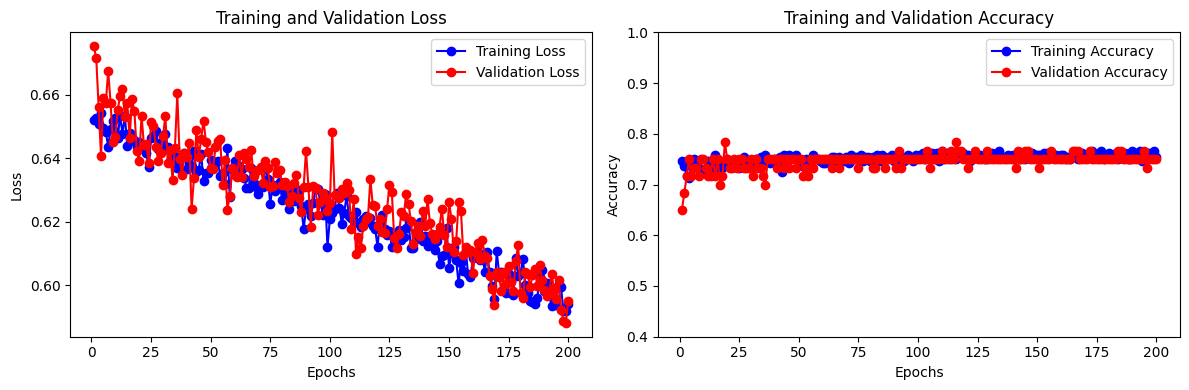

Train done.
Train saved.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          ok       0.75      1.00      0.86        45
         out       0.00      0.00      0.00        15

    accuracy                           0.75        60
   macro avg       0.38      0.50      0.43        60
weighted avg       0.56      0.75      0.64        60

==========Cross Validation Fold 2==========
trainLoss: 0.7078 Acc: 0.3917
valLoss: 0.7219 Acc: 0.3333
trainLoss: 0.7134 Acc: 0.3708
valLoss: 0.7140 Acc: 0.3667
trainLoss: 0.7126 Acc: 0.3625
valLoss: 0.7199 Acc: 0.3333
trainLoss: 0.7152 Acc: 0.3833
valLoss: 0.7201 Acc: 0.3333
trainLoss: 0.7084 Acc: 0.4125
valLoss: 0.7160 Acc: 0.4167
trainLoss: 0.7171 Acc: 0.3625
valLoss: 0.7402 Acc: 0.3667
trainLoss: 0.7069 Acc: 0.4458
valLoss: 0.7202 Acc: 0.2833
trainLoss: 0.7054 Acc: 0.4458
valLoss: 0.7220 Acc: 0.3833
trainLoss: 0.7043 Acc: 0.4500
valLoss: 0.7239 Acc: 0.2667
trainLoss: 0.7091 Acc: 0.4375
valLoss: 0.7214 Acc: 0.3333
trainLoss: 0.7090 Acc: 0.4167
valLoss: 0.7243 Acc

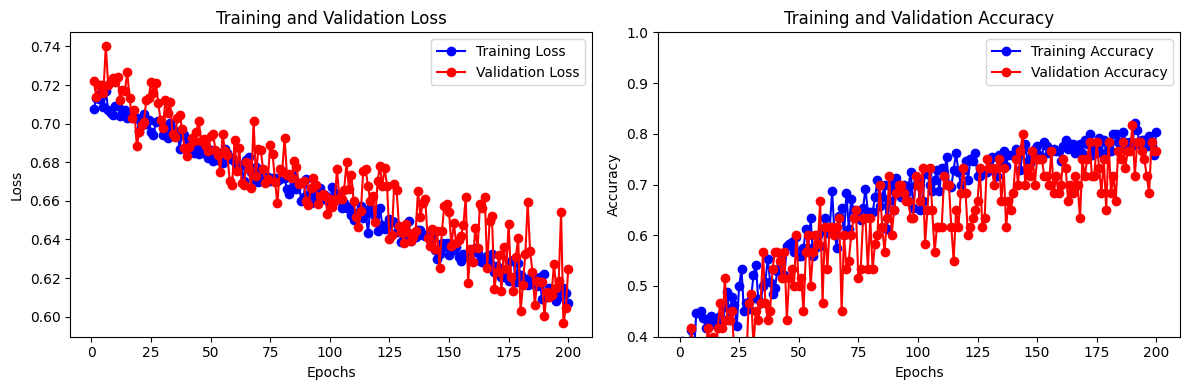

Train done.
Train saved.
              precision    recall  f1-score   support

          ok       0.86      0.82      0.84        45
         out       0.53      0.60      0.56        15

    accuracy                           0.77        60
   macro avg       0.69      0.71      0.70        60
weighted avg       0.78      0.77      0.77        60

==========Cross Validation Fold 3==========
trainLoss: 0.6745 Acc: 0.6000
valLoss: 0.6863 Acc: 0.5000
trainLoss: 0.6703 Acc: 0.6458
valLoss: 0.6838 Acc: 0.6000
trainLoss: 0.6696 Acc: 0.6583
valLoss: 0.6768 Acc: 0.6333
trainLoss: 0.6756 Acc: 0.6167
valLoss: 0.6483 Acc: 0.8000
trainLoss: 0.6694 Acc: 0.6458
valLoss: 0.6683 Acc: 0.7333
trainLoss: 0.6761 Acc: 0.6125
valLoss: 0.6593 Acc: 0.7167
trainLoss: 0.6710 Acc: 0.6417
valLoss: 0.6713 Acc: 0.6000
trainLoss: 0.6649 Acc: 0.6958
valLoss: 0.6648 Acc: 0.6500
trainLoss: 0.6681 Acc: 0.6667
valLoss: 0.6630 Acc: 0.7333
trainLoss: 0.6635 Acc: 0.6750
valLoss: 0.6550 Acc: 0.6500
trainLoss: 0.6609 Acc: 0

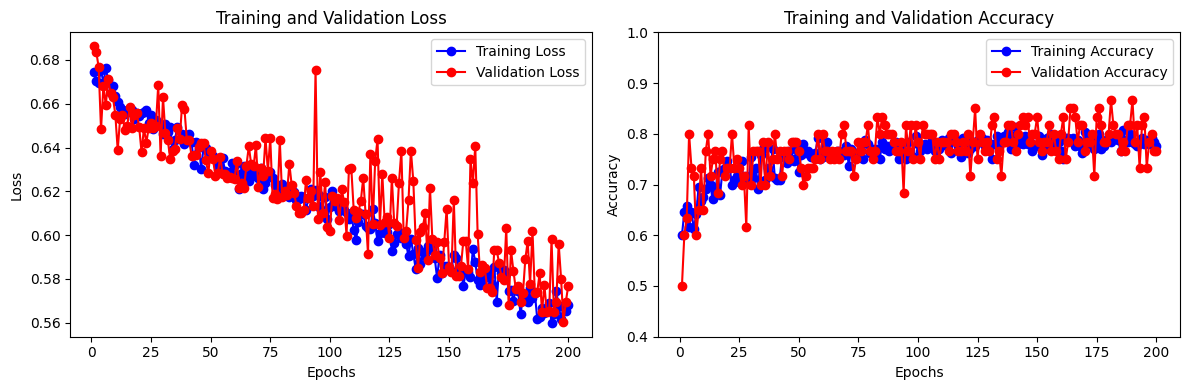

Train done.
Train saved.
              precision    recall  f1-score   support

          ok       0.78      0.96      0.86        45
         out       0.60      0.20      0.30        15

    accuracy                           0.77        60
   macro avg       0.69      0.58      0.58        60
weighted avg       0.74      0.77      0.72        60

==========Cross Validation Fold 4==========
trainLoss: 0.6847 Acc: 0.5583
valLoss: 0.6910 Acc: 0.5167
trainLoss: 0.6858 Acc: 0.5583
valLoss: 0.6923 Acc: 0.5000
trainLoss: 0.6854 Acc: 0.5792
valLoss: 0.6937 Acc: 0.5167
trainLoss: 0.6836 Acc: 0.5708
valLoss: 0.7199 Acc: 0.3333
trainLoss: 0.6814 Acc: 0.5625
valLoss: 0.7005 Acc: 0.4167
trainLoss: 0.6831 Acc: 0.5583
valLoss: 0.6926 Acc: 0.4833
trainLoss: 0.6851 Acc: 0.5417
valLoss: 0.6965 Acc: 0.4833
trainLoss: 0.6720 Acc: 0.6500
valLoss: 0.6917 Acc: 0.5167
trainLoss: 0.6757 Acc: 0.5792
valLoss: 0.6868 Acc: 0.5500
trainLoss: 0.6793 Acc: 0.5792
valLoss: 0.7012 Acc: 0.5167
trainLoss: 0.6767 Acc: 0

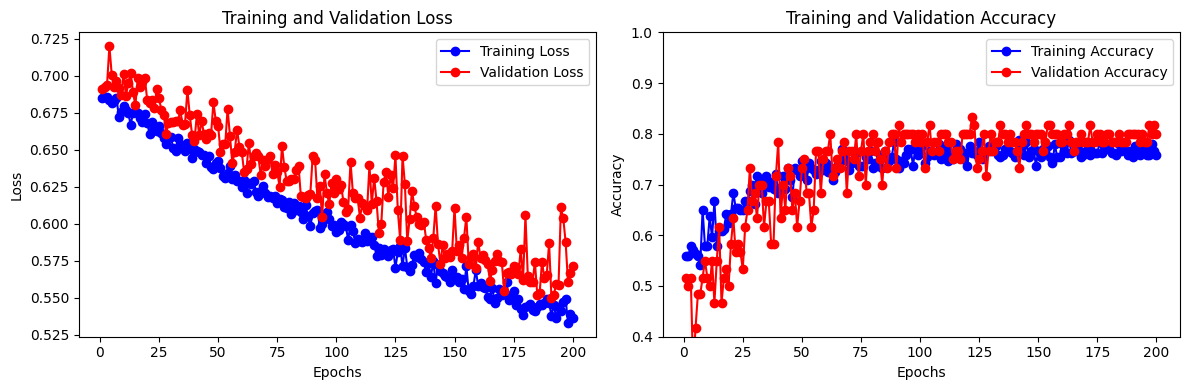

Train done.
Train saved.
              precision    recall  f1-score   support

          ok       0.79      1.00      0.88        45
         out       1.00      0.20      0.33        15

    accuracy                           0.80        60
   macro avg       0.89      0.60      0.61        60
weighted avg       0.84      0.80      0.75        60

==========Cross Validation Fold 5==========
trainLoss: 0.6665 Acc: 0.6875
valLoss: 0.6627 Acc: 0.6833
trainLoss: 0.6673 Acc: 0.6708
valLoss: 0.6643 Acc: 0.7167
trainLoss: 0.6638 Acc: 0.6583
valLoss: 0.6441 Acc: 0.7500
trainLoss: 0.6615 Acc: 0.6958
valLoss: 0.6342 Acc: 0.8000
trainLoss: 0.6615 Acc: 0.6875
valLoss: 0.6493 Acc: 0.7500
trainLoss: 0.6570 Acc: 0.7125
valLoss: 0.6504 Acc: 0.7167
trainLoss: 0.6641 Acc: 0.6500
valLoss: 0.6364 Acc: 0.7667
trainLoss: 0.6536 Acc: 0.7167
valLoss: 0.6400 Acc: 0.7500
trainLoss: 0.6543 Acc: 0.7125
valLoss: 0.6504 Acc: 0.7667
trainLoss: 0.6589 Acc: 0.6917
valLoss: 0.6343 Acc: 0.7333
trainLoss: 0.6547 Acc: 0

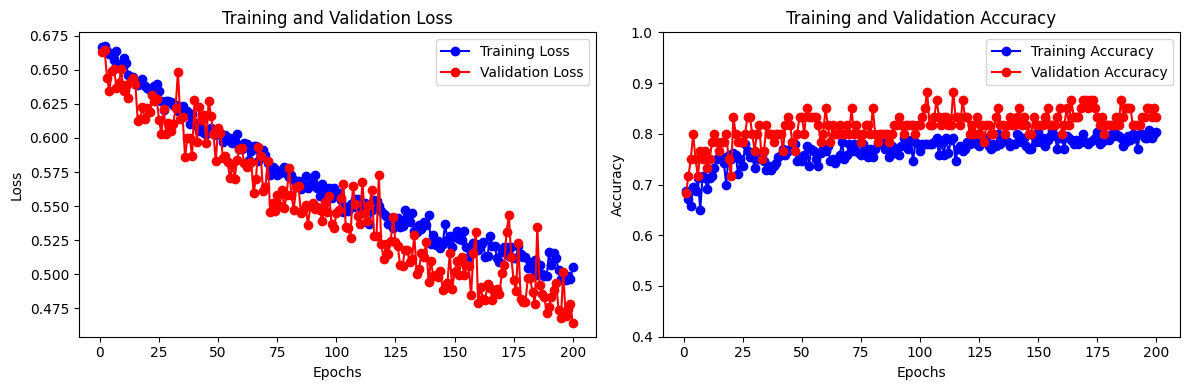

Train done.
Train saved.
              precision    recall  f1-score   support

          ok       0.82      1.00      0.90        46
         out       1.00      0.29      0.44        14

    accuracy                           0.83        60
   macro avg       0.91      0.64      0.67        60
weighted avg       0.86      0.83      0.80        60



In [26]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# データセットの分割とデータローダーの作成
for fold, (train_index, val_index) in enumerate(kfold.split(image_paths,labels), 1):
    print(f'==========Cross Validation Fold {fold}==========')
    image_directory = '/content/drive/MyDrive/lernig/OBI_ref/image'
    label_directory = '/content/drive/MyDrive/lernig/OBI_ref/label'


    image_paths, labels = update_xml_paths(image_directory, label_directory)
    train_paths = [image_paths[i] for i in train_index]
    train_labels = [labels[i] for i in train_index]
    val_paths = [image_paths[i] for i in val_index]
    val_labels = [labels[i] for i in val_index]

    train_dataset = ImageDataset(train_paths, train_labels, transform=data_transform['train'])
    val_dataset = ImageDataset(val_paths, val_labels, transform=data_transform['val'])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    dataloaders  = {"train":train_loader, "val":val_loader}

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    # 事前学習済みモデルの全結合層の出力ユニット数をデータのクラス数に置き換え
    num_classes = len(set(train_labels))
    net.fc = nn.Linear(2048, num_classes)

# ここでデータローダーを使用して学習や検証を行う
    data_size = {'train': len(train_dataset), 'val': len(val_dataset)}
    train_model(model, criterion, optimizer, num_epochs)
    print('Train done.')
    file_path = os.path.join(directory_path, f'{file_name}_{str(fold)}.pth')
    # モデルの保存
    torch.save(model.state_dict(), file_path)
    print('Train saved.')
    model.load_state_dict(torch.load(file_path))
    model.eval()
    model.to(device)

    y_pred = []
    y_true = []
    with torch.no_grad():
      for images, labels in val_loader:
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          y_pred.extend(predicted.cpu().numpy())
          y_true.extend(labels.cpu().numpy())

    # 評価
    target_names = ['ok', 'out']  # クラス名をリストで指定
    print(classification_report(y_true, y_pred, target_names=target_names))